In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier

# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Feature selection
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES", "CVAFIB", "HYPERCHO", "CBSTROKE", "NACCMOM", "NACCDAD", "DEPOTHR", "MEMORY"
]

# Binary conversion for categorical variables
binary_conversion_cols = [
    "ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"
]
df[binary_conversion_cols] = df[binary_conversion_cols].map(lambda x: 1 if x == 1 or x == 2 else 0)

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"]) * (df["Age_Education_Ratio"])
df["NACCHIST"] = (df["NACCFAM"].astype(float) + 1) * (df["NACCMOM"].astype(float) + 1) * (df["NACCDAD"].astype(float) + 1)
df["Education_Cognition"] = df["EDUC"] + df["NACCMOCA"]
df["Cardio_Lifestyle_Interaction"] = (df["Cardio_Risk"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Lifestyle_Interaction"] = (df["DEP2YRS"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Cardio_Impact"] = (0.6 * (df["DEP2YRS"] + 1)) + (0.4 * (df["Cardio_Risk"] + 1))
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "Cognitive_Risk",
                       "NACCHIST", "Education_Cognition", "Cardio_Lifestyle_Interaction",
                       "Dep_Lifestyle_Interaction", "Dep_Cardio_Impact"]
feature_list = original_features + engineered_features
feature_list.remove("MEMORY")
feature_list.remove("NACCMOM")
feature_list.remove("NACCDAD")
feature_list.remove("NACCFAM")
y = df["DEMENTED"]
X = df[feature_list]

# Identify column types
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA"] + engineered_features
binary_cols = ["SEX", "TOBAC100", "DEP2YRS", "DEPOTHR"] + binary_conversion_cols
categorical_cols = ["NACCNIHR"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Updated
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ================================
# 3. Hyperparameter Tuning with Optuna
# ================================
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Updated
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),  # Updated
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),  # Updated
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 10.0, log=True),  # Updated
        "verbose": 0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test), early_stopping_rounds=30, verbose=0)
    y_pred = model.predict(X_test_processed)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

# ================================
# 4. Train & Evaluate Final Model
# ================================
final_model = CatBoostClassifier(**best_params, verbose=1)  # Updated
final_model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test), early_stopping_rounds=30, verbose=100)
y_pred = final_model.predict(X_test_processed)

# Evaluation Metrics
print(classification_report(y_test, y_pred, target_names=["Not Demented", "Demented"]))  # Updated
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_pred))

<ipython-input-1-80007698e598>:15: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path
[I 2025-02-17 13:12:59,513] A new study created in memory with name: no-name-2c11682e-c521-4cb8-9d73-028d97974aa7
[I 2025-02-17 13:13:05,175] Trial 0 finished with value: 0.9129750257762449 and parameters: {'iterations': 125, 'depth': 6, 'learning_rate': 0.019142606484709144, 'l2_leaf_reg': 0

0:	learn: 0.5047221	test: 0.5051053	best: 0.5051053 (0)	total: 35.4ms	remaining: 14.9s
100:	learn: 0.1593846	test: 0.1780024	best: 0.1780024 (100)	total: 3.71s	remaining: 11.8s
200:	learn: 0.1439118	test: 0.1763110	best: 0.1763110 (200)	total: 7.6s	remaining: 8.32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1762869792
bestIteration = 221

Shrink model to first 222 iterations.
              precision    recall  f1-score   support

Not Demented       0.95      0.96      0.95     42109
    Demented       0.90      0.88      0.89     17480

    accuracy                           0.94     59589
   macro avg       0.92      0.92      0.92     59589
weighted avg       0.93      0.94      0.93     59589

Test Set ROC-AUC Score: 0.9181281472410627


<ipython-input-2-f79e0a0e0abf>:17: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path
[I 2025-02-17 13:20:30,279] A new study created in memory with name: no-name-0e19f03e-bb88-4763-9bf6-d853a4c29c9b
[I 2025-02-17 13:20:43,804] Trial 0 finished with value: 0.9147933107349766 and parameters: {'iterations': 305, 'depth': 8, 'learning_rate': 0.010572384457087275, 'l2_leaf_reg': 9

0:	learn: 0.5033815	test: 0.5038016	best: 0.5038016 (0)	total: 37.6ms	remaining: 14.9s
100:	learn: 0.1585182	test: 0.1782642	best: 0.1782642 (100)	total: 3.85s	remaining: 11.3s
200:	learn: 0.1409850	test: 0.1774093	best: 0.1773583 (198)	total: 7.96s	remaining: 7.76s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1773171944
bestIteration = 237

Shrink model to first 238 iterations.
              precision    recall  f1-score   support

Not Demented       0.95      0.96      0.95     42109
    Demented       0.90      0.88      0.89     17480

    accuracy                           0.93     59589
   macro avg       0.92      0.92      0.92     59589
weighted avg       0.93      0.93      0.93     59589

Test Set ROC-AUC Score: 0.918126518988831


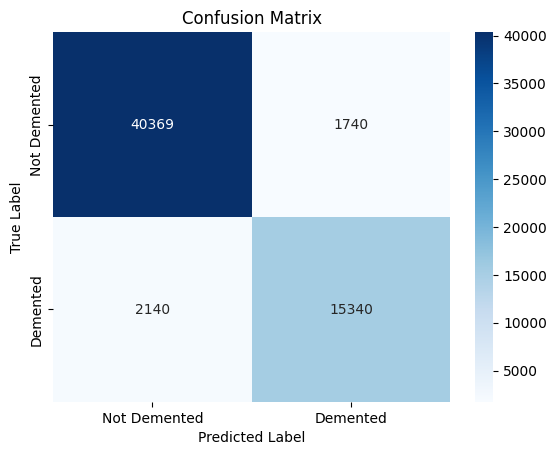

In [2]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Feature selection
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES", "CVAFIB", "HYPERCHO", "CBSTROKE", "NACCMOM", "NACCDAD", "DEPOTHR", "MEMORY"
]

# Binary conversion for categorical variables
binary_conversion_cols = [
    "ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"
]
df[binary_conversion_cols] = df[binary_conversion_cols].map(lambda x: 1 if x == 1 or x == 2 else 0)

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"]) * (df["Age_Education_Ratio"])
df["NACCHIST"] = (df["NACCFAM"].astype(float) + 1) * (df["NACCMOM"].astype(float) + 1) * (df["NACCDAD"].astype(float) + 1)
df["Cognitive_AgeEdu_Interaction"] = (df["Cognitive_Risk"].astype(float) + 1) * (df["Age_Education_Ratio"].astype(float) + 1)
df["Education_Cognition"] = df["EDUC"] + df["NACCMOCA"]
df["Cardio_Lifestyle_Interaction"] = (df["Cardio_Risk"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Lifestyle_Interaction"] = (df["DEP2YRS"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Cardio_Impact"] = (0.6 * (df["DEP2YRS"] + 1)) + (0.4 * (df["Cardio_Risk"] + 1))
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "Cognitive_Risk",
                       "NACCHIST", "Education_Cognition", "Cardio_Lifestyle_Interaction","Cognitive_AgeEdu_Interaction",
                       "Dep_Lifestyle_Interaction", "Dep_Cardio_Impact"]
feature_list = original_features + engineered_features
feature_list.remove("MEMORY")
feature_list.remove("NACCMOM")
feature_list.remove("NACCDAD")
feature_list.remove("NACCFAM")
y = df["DEMENTED"]
X = df[feature_list]

# Identify column types
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA"] + engineered_features
binary_cols = ["SEX", "TOBAC100", "DEP2YRS", "DEPOTHR"] + binary_conversion_cols
categorical_cols = ["NACCNIHR"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Updated
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ================================
# 3. Hyperparameter Tuning with Optuna
# ================================
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Updated
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),  # Updated
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),  # Updated
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 10.0, log=True),  # Updated
        "verbose": 0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test), early_stopping_rounds=30, verbose=0)
    y_pred = model.predict(X_test_processed)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

# ================================
# 4. Train & Evaluate Final Model
# ================================
final_model = CatBoostClassifier(**best_params, verbose=1)  # Updated
final_model.fit(X_train_processed, y_train, eval_set=(X_test_processed, y_test), early_stopping_rounds=30, verbose=100)
y_pred = final_model.predict(X_test_processed)

# Evaluation Metrics
print(classification_report(y_test, y_pred, target_names=["Not Demented", "Demented"]))  # Updated
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Demented", "Demented"], 
            yticklabels=["Not Demented", "Demented"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-3-b61041008bc0>:17: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path
[I 2025-02-17 13:26:53,331] A new study created in memory with name: no-name-ae00f293-fd4f-42d3-8dc3-8bae19c461e0
[I 2025-02-17 13:27:02,490] Trial 0 finished with value: 0.9042707767473375 and parameters: {'iterations': 196, 'depth': 9, 'learning_rate': 0.01768481138077227, 'l2_leaf_reg': 0.

0:	learn: 0.5571007	test: 0.5570510	best: 0.5570510 (0)	total: 36ms	remaining: 9.83s
100:	learn: 0.1724576	test: 0.1897032	best: 0.1897032 (100)	total: 3.92s	remaining: 6.72s
200:	learn: 0.1552140	test: 0.1885864	best: 0.1883938 (178)	total: 7.45s	remaining: 2.71s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1882298048
bestIteration = 213

Shrink model to first 214 iterations.
              precision    recall  f1-score   support

Not Demented       0.94      0.96      0.95     21055
    Demented       0.89      0.86      0.88      8740

    accuracy                           0.93     29795
   macro avg       0.92      0.91      0.91     29795
weighted avg       0.93      0.93      0.93     29795

Test Set ROC-AUC Score: 0.9080184049946556


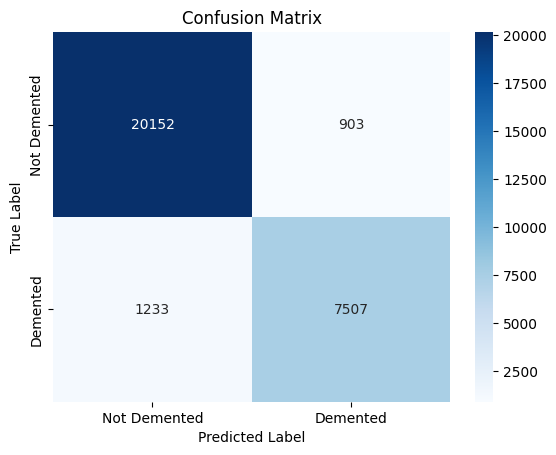

In [3]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visi

# Feature selection
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES", "CVAFIB", "HYPERCHO", "CBSTROKE", "NACCMOM", "NACCDAD", "DEPOTHR"
]

# Binary conversion for categorical variables
binary_conversion_cols = [
    "ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"
]
df[binary_conversion_cols] = df[binary_conversion_cols].map(lambda x: 1 if x == 1 or x == 2 else 0)

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"]) * (df["Age_Education_Ratio"])
df["NACCHIST"] = (df["NACCFAM"].astype(float) + 1) * (df["NACCMOM"].astype(float) + 1) * (df["NACCDAD"].astype(float) + 1)
df["Education_Cognition"] = df["EDUC"] + df["NACCMOCA"]
df["Cardio_Lifestyle_Interaction"] = (df["Cardio_Risk"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Lifestyle_Interaction"] = (df["DEP2YRS"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Cardio_Impact"] = (0.6 * (df["DEP2YRS"] + 1)) + (0.4 * (df["Cardio_Risk"] + 1))
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "Cognitive_Risk",
                       "NACCHIST", "Education_Cognition", "Cardio_Lifestyle_Interaction",
                       "Dep_Lifestyle_Interaction", "Dep_Cardio_Impact"]
feature_list = original_features + engineered_features
feature_list.remove("NACCMOM")
feature_list.remove("NACCDAD")
feature_list.remove("NACCFAM")
y = df["DEMENTED"]
X = df[feature_list]

# Identify column types
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA"] + engineered_features
binary_cols = ["SEX", "TOBAC100", "DEP2YRS", "DEPOTHR"] + binary_conversion_cols
categorical_cols = ["NACCNIHR"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Updated
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Train-Validation-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Preprocess the data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# ================================
# 3. Hyperparameter Tuning with Optuna
# ================================
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Updated
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),  # Updated
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),  # Updated
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 10.0, log=True),  # Updated
        "verbose": 0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train_processed, y_train, eval_set=(X_val_processed, y_val), early_stopping_rounds=30, verbose=0)
    y_pred = model.predict(X_val_processed)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

# ================================
# 4. Train & Evaluate Final Model
# ================================
final_model = CatBoostClassifier(**best_params, verbose=1)  # Updated
history = final_model.fit(
    X_train_processed, y_train,
    eval_set=(X_val_processed, y_val),
    early_stopping_rounds=30,
    verbose=100
)

# Plot Training vs Validation Curve


# Evaluation Metrics
y_pred = final_model.predict(X_test_processed)
print(classification_report(y_test, y_pred, target_names=["Not Demented", "Demented"]))  # Updated
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Demented", "Demented"], 
            yticklabels=["Not Demented", "Demented"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()